## Разрешение анафоры и кореференции

Традиционный подход к разрешению анафоры/кореференции — классификация пар именных групп (являются кореферентными или нет). В таком случае самая содержательная задача — придумать признаки для классификации. Какие они могут быть:

* морфологические (согласование)
* синтаксические (роль в предложении, расстояние по дереву, тип вершины и т.д.)
* онтологические (один класс, расстояние и т.д.)
* ...

In [1]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/rhubarb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.corpus import wordnet as wn
from matplotlib import pyplot as plt
%matplotlib inline

В wordnet все организовано в синсеты - наборы синонимов. 

In [3]:
len(list(wn.all_synsets()))

117659

Из них существительных:


In [4]:
len(list(wn.all_synsets('n')))

82115

А глаголов:

In [5]:
len(list(wn.all_synsets('v')))

13767

А прилагательных:

In [6]:
len(list(wn.all_synsets('a')))

18156

Синсет для слова можно достать вот так:

In [7]:
wn.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

Можно ограничить часть речи:

In [9]:
wn.synsets('content', pos='v')

[Synset('content.v.01'), Synset('content.v.02')]

У многих из них есть определения:

In [10]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + synset.definition())


day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)
day - an era of existence or influence
day - the period of time taken by a particular planet (e.g. Mars) to make a complete rotation on its axis
day - the time for one complete rotation of the earth relative to a particular star, about 4 minutes shorter than a mean solar day
day - a period of opportunity
day - United States writer best known for his autobiographical works (1874-1935)


И даже примеры употребления:

In [11]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + ' | '.join(synset.examples()))

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed
day - in the day of the dinosaurs | in the days of the Roman Empire | in the days of sailing ships | he was a successful pianist in his day
day - how long is a day on Jupiter?
day - 
day - he deserves his day in court | every dog has his day
day - 


Синсеты связаны между собой стандартными отношениями (гипонимии, антонимии, синонимии, меронимии).

In [12]:
s = wn.synsets('car')[0]
s.part_meronyms()

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01'),
 Synset('buffer.n.06'),
 Synset('bumper.n.02'),
 Synset('car_door.n.01'),
 Synset('car_mirror.n.01'),
 Synset('car_seat.n.01'),
 Synset('car_window.n.01'),
 Synset('fender.n.01'),
 Synset('first_gear.n.01'),
 Synset('floorboard.n.02'),
 Synset('gasoline_engine.n.01'),
 Synset('glove_compartment.n.01'),
 Synset('grille.n.02'),
 Synset('high_gear.n.01'),
 Synset('hood.n.09'),
 Synset('luggage_compartment.n.01'),
 Synset('rear_window.n.01'),
 Synset('reverse.n.02'),
 Synset('roof.n.02'),
 Synset('running_board.n.01'),
 Synset('stabilizer_bar.n.01'),
 Synset('sunroof.n.01'),
 Synset('tail_fin.n.02'),
 Synset('third_gear.n.01'),
 Synset('window.n.02')]

Антонимы только достаются не очень удобно:

In [13]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [14]:
#!pip install networkx

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


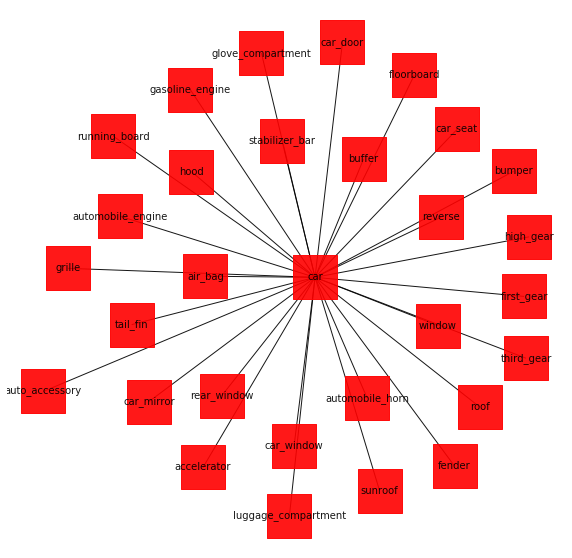

In [15]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')



Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [16]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]

bike.path_similarity(car)

0.3333333333333333

Есть и другие метрики:

In [17]:
wn.lch_similarity(bike, car)

2.538973871058276

In [18]:
wn.wup_similarity(bike, car)

0.9166666666666666

Есть ещё ворднет для русского. С похожим интерфейсом.

In [19]:
#!pip install wiki_ru_wordnet

In [20]:
from wiki_ru_wordnet import WikiWordnet
import re
ruwn = WikiWordnet()

In [21]:
s = ruwn.get_synsets('дерево')[0]

In [22]:
for w in s.get_words():
    print(w.lemma())
    print(w.definition())
    print()

дерево
дерево~ru~дерево~ru~{{ботан.|ru}} многолетнее, как правило, крупное [[растение]] с твёрдым [[ствол]]ом, мощной корневой системой и образующими крону ветвями, покрытыми листьями или иголками {{пример|Люди с их топорами и пилами … безжалостно губили мощные дубы, широкие осины, стройные берёзки и тополя и другие {{выдел|деревья}}.|Л. А. Чарская|Золотая свирель|1912|источник=НКРЯ}} {{пример|Туманная меланхолия неизменно накреняла {{выдел|дерева́}}. Стояли {{выдел|дерева́}} наклонённые.|Андрей Белый|Северная симфония|1917|источник=НКРЯ}} {{пример|Можжевел{{-}}{{выдел|дерево}} скрытное, колкое, не допускающее в себя, замкнутое, строгое к жизни, самое мудрое из наших {{выдел|дере́в}}.|Л. М. Леонов|Барсуки|1924|источник=НКРЯ}} {{пример|{{--}}Знаешь, по чему у {{выдел|дерёв}} считают года?..|С. А. Клычков|Чертухинский балакирь|1926|источник=НКРЯ}} {{пример|Ми́ны рвали́сь в {{выдел|дерева́х}}.|Виктор Астафьев|Весёлый солдат|дата=1987–1997||Новый Мир|дата издания=1998 г.|источник=НКРЯ}} {{

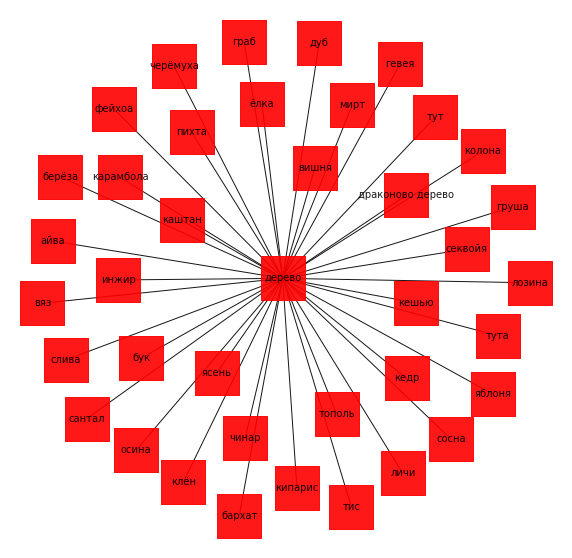

In [23]:
words = ruwn.get_synsets('дерево')
first_synset = words[0]
hyponyms = ruwn.get_hyponyms(first_synset)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge('дерево',
               list(w.get_words())[0].lemma())

plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')

## РуТез
[ещё один тезаурус для русского языка](https://www.labinform.ru/pub/ruthes/index.htm)
* более 31.5 понятий, 111.5 тысяч различных текстовых входов (слов и выражений русского языка), более 130 тысяч с учетом значений многозначных слов;
* раздаётся в XML по запросу, мы будем использовать уже предобработанную версию.

In [24]:
#!wget https://github.com/sjut/HSE-Compling/raw/master/seminars/data/relations_with_concepts.csv

In [25]:
import csv

rels_list = []
with open("relations_with_concepts.csv", newline='', encoding='utf8') as rels:
    reader = csv.DictReader(rels, delimiter="\t")
    for row in reader:
        rels_list.append(row)


def get_supc2(concept_list, rels_list, has_up=True, depth=0, max_depth=-1):
    """
    Get list of all hypernym chains of the query
    - up a level
    - add all 'выше' concepts to list
    [[level_1, level_2.1, level_3.1], [level_1, level_2.2, level_3.2], etc...]

    :param concept_list: search input
    :param rels_list: imported set of relations
    :param max_depth: maximum allowed number of hypernyms
    :param has_up: (internal) bool(current top concept has a superconcept)
    :param depth: (internal) current depth in the ontology
    :return: list of superconcept for every meaning of query
    """
    new_cl = concept_list[:]
    if (not has_up) or depth >= max_depth > 0:
        return new_cl
    has_up = False
    for chain in concept_list:
        index = new_cl.index(chain)
        word = chain[-1]
        for row in rels_list:
            new_chain = chain[:]
            if row['from'].lower() == word.lower() and row['relation'] == 'ВЫШЕ':
                new_chain.append(row['to'].lower())
                new_cl.insert(index + 1, new_chain)
                has_up = True
        if has_up:
            new_cl.remove(chain)
    return get_supc2(new_cl, rels_list, has_up, depth+1, max_depth)


def get_supc(concept_list, rels_list, has_up=True, depth=0, max_depth=-1):
    """
    Find list of all hypernyms of query by level down
    [[level_1], [level_2.1, level_2.2], [level_3.1, level_3.2, level_3.3], etc...]

    :param concept_list: search input
    :param rels_list: imported set of relations
    :param max_depth: maximum allowed number of hyponyms
    :param has_up: (internal) bool(current top concept has a subconcept)
    :param depth: (internal) current depth in the ontology
    :return: list of subconcepts for every meaning of query
    """
    if (not has_up) or depth >= max_depth > 0:
        return concept_list
    has_up = False
    new_list = []
    for word in concept_list[-1]:
        for row in rels_list:
            if row['from'].lower() == word.lower() and row['relation'] == 'ВЫШЕ':
                if all(row['to'].lower() not in hypo for hypo in concept_list):
                    new_list.append(row['to'].lower())
                    has_up = True
    if has_up:
        concept_list.append(new_list)
    return get_supc(concept_list, rels_list, has_up, depth + 1, max_depth)


def get_subc2(concept_list, rels_list, has_down=True, depth=0, max_depth=-1):
    """
    Get list of all hyponym chains for word in query
    - down a level
    - add all 'ниже' concepts to list
    [[level_1, level_2.1, level_3.1], [level_1, level_2.2, level_3.2], etc...]

    :param concept_list: search input
    :param rels_list: imported set of relations
    :param max_depth: maximum allowed number of hyponyms
    :param has_down: (internal) bool(current top concept has a subconcept)
    :param depth: (internal) current depth in the ontology
    :return: list of subconcepts for every meaning of query
    """
    new_cl = concept_list[:]
    if (not has_down) or depth >= max_depth > 0:
        return new_cl
    for chain in concept_list:
        has_down = False
        index = new_cl.index(chain)
        word = chain[-1]
        for row in rels_list:
            new_chain = chain[:]
            if row['from'].lower() == word.lower() and row['relation'] == 'НИЖЕ':
                new_chain.append(row['to'].lower())
                new_cl.insert(index + 1, new_chain)
                has_down = True
        if has_down:
            new_cl.remove(chain)
    return get_subc2(new_cl, rels_list, has_down, depth+1, max_depth)


def get_subc(concept_list, rels_list, has_down=True, depth=0, max_depth=-1):
    """
    Find list of all hyponyms of query by level down
    [[level_1], [level_2.1, level_2.2], [level_3.1, level_3.2, level_3.3], etc...]

    :param concept_list: search input
    :param rels_list: imported set of relations
    :param max_depth: maximum allowed number of hyponyms
    :param has_down: (internal) bool(current top concept has a subconcept)
    :param depth: (internal) current depth in the ontology
    :return: list of subconcepts for every meaning of query
    """
    if (not has_down) or depth >= max_depth > 0:
        return concept_list
    has_down = False
    new_list = []
    for word in concept_list[-1]:
        for row in rels_list:
            if row['from'].lower() == word.lower() and row['relation'] == 'НИЖЕ':
                if all(row['to'].lower() not in hypo for hypo in concept_list):
                    new_list.append(row['to'].lower())
                    has_down = True
    if has_down:
        concept_list.append(new_list)
    return get_subc(concept_list, rels_list, has_down, depth+1, max_depth)

Получить все гиперонимы для списка концептов (объединенные в списки по уровням).

In [26]:
get_supc([['собака'], ['кошка']], rels_list)

[['собака'],
 ['кошка'],
 ['домашнее животное', 'кошачьи'],
 ['животное', 'хищное млекопитающее'],
 ['живой организм', 'млекопитающее', 'дикое животное', 'хищное животное'],
 ['биологическая сущность', 'позвоночное животное'],
 ['физическая сущность'],
 ['постоянная сущность']]

Получить все гиперонимы для списка концептов (объединенные в списки по концепту).

In [27]:
get_supc2([['собака'], ["кошка"]], rels_list)

[['собака',
  'домашнее животное',
  'животное',
  'живой организм',
  'биологическая сущность',
  'физическая сущность',
  'постоянная сущность'],
 ['собака',
  'млекопитающее',
  'позвоночное животное',
  'животное',
  'живой организм',
  'биологическая сущность',
  'физическая сущность',
  'постоянная сущность'],
 ['кошка',
  'кошачьи',
  'хищное млекопитающее',
  'хищное животное',
  'животное',
  'живой организм',
  'биологическая сущность',
  'физическая сущность',
  'постоянная сущность'],
 ['кошка',
  'кошачьи',
  'хищное млекопитающее',
  'дикое животное',
  'животное',
  'живой организм',
  'биологическая сущность',
  'физическая сущность',
  'постоянная сущность'],
 ['кошка',
  'кошачьи',
  'хищное млекопитающее',
  'млекопитающее',
  'позвоночное животное',
  'животное',
  'живой организм',
  'биологическая сущность',
  'физическая сущность',
  'постоянная сущность']]

Получить все гипонимы для списка концептов (объединенные в списки по уровням).

In [28]:
get_subc([['собака']], rels_list)

[['собака'],
 ['служебная собака',
  'охотничья собака',
  'комнатная собака',
  'пудель',
  'бульдог',
  'пинчер',
  'щенок (собака)',
  'кобель (собака)',
  'беспородная собака',
  'ротвейлер',
  'лабрадор (порода собак)',
  'чихуахуа (порода собак)'],
 ['поисковая собака',
  'овчарка',
  'боксер (собака)',
  'такса (собака)',
  'волкодав',
  'лайка (собака)',
  'спаниель',
  'терьер',
  'борзая собака',
  'легавая собака',
  'болонка',
  'доберман'],
 ['немецкая овчарка',
  'кокер-спаниель',
  'питбультерьер',
  'йоркширский терьер',
  'стаффордширский терьер',
  'сеттер']]

Получить все гипонимы для списка концептов (объединенные в списки по концепту).

In [29]:
get_subc2([['собака']], rels_list)

[['собака', 'чихуахуа (порода собак)'],
 ['собака', 'лабрадор (порода собак)'],
 ['собака', 'ротвейлер'],
 ['собака', 'беспородная собака'],
 ['собака', 'кобель (собака)'],
 ['собака', 'щенок (собака)'],
 ['собака', 'пинчер', 'доберман'],
 ['собака', 'бульдог'],
 ['собака', 'пудель'],
 ['собака', 'комнатная собака', 'болонка'],
 ['собака', 'комнатная собака', 'пудель'],
 ['собака', 'охотничья собака', 'легавая собака', 'сеттер'],
 ['собака', 'охотничья собака', 'борзая собака'],
 ['собака', 'охотничья собака', 'терьер', 'стаффордширский терьер'],
 ['собака', 'охотничья собака', 'терьер', 'йоркширский терьер'],
 ['собака', 'охотничья собака', 'терьер', 'питбультерьер'],
 ['собака', 'охотничья собака', 'спаниель', 'кокер-спаниель'],
 ['собака', 'охотничья собака', 'лайка (собака)'],
 ['собака', 'охотничья собака', 'волкодав'],
 ['собака', 'охотничья собака', 'такса (собака)'],
 ['собака', 'служебная собака', 'боксер (собака)'],
 ['собака', 'служебная собака', 'овчарка', 'немецкая овчарка

## Классификатор кореферентности
— является ли пара упоминаний (именных групп) кореферентными?
Что нужно?
* собрать список пар;
* представить в виде признаков;
* обучить классификатор.

Будем использовать данные корпуса [RuCor]() и [код М. Ионова](https://github.com/max-ionov/rucoref) для соревнований Диалога.

In [30]:
#!git clone https://github.com/max-ionov/rucoref.git
#!rm -rf rucoref/external/reference-coreference-scorers
#!cd rucoref/external && git clone https://github.com/conll/reference-coreference-scorers.git && cd -

Скачиваем размеченные данные - группы (упоминания + кореф-связи) и сам корпус (тексты разобраны Malt-парсером).

In [31]:
#!wget https://github.com/sjut/HSE-Compling/raw/master/seminars/data/Groups.test.txt
#!wget https://github.com/sjut/HSE-Compling/raw/master/seminars/data/Groups.train.txt
#!wget https://github.com/sjut/HSE-Compling/raw/master/seminars/data/Tokens.train.txt
#!wget https://github.com/sjut/HSE-Compling/raw/master/seminars/data/Tokens.test.txt

In [32]:
%cd 'rucoref'
from anaphoralib.corpora import rueval
from anaphoralib.tagsets import multeast
from anaphoralib.tagsets.utils import same_grammemmes
from anaphoralib.experiments import mentionpair
from anaphoralib.experiments import coref_utils
from anaphoralib import utils
from anaphoralib.experiments import utils as exp_utils
%cd '..'

scorer_path = 'rucoref/external/reference-coreference-scorers/scorer.pl'

/Users/rhubarb/PycharmProjects/hse-nlp/fall2019/4course/rucoref
/Users/rhubarb/PycharmProjects/hse-nlp/fall2019/4course


In [33]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import export_graphviz

In [34]:
rucoref_train = rueval.RuCorefCorpus(multeast, rueval)
rucoref_test = rueval.RuCorefCorpus(multeast, rueval)

In [ ]:
exp_utils.load_corpus(rucoref_train, 'Tokens.parsed.train.txt', 'Groups.train.txt')

In [ ]:
exp_utils.load_corpus(rucoref_test, 'Tokens.parsed.test.txt', 'Groups.test.txt')

In [ ]:
group_ok = lambda g: g.tag.startswith('N') or (g.tag.startswith('P') and g.lemma[0] in multeast.coref_pronouns)

In [ ]:
gs_mentions, gs_group_ids = coref_utils.get_gs_groups(rucoref_test)
gs_groups = gs_mentions

pred_mentions, pred_group_ids = coref_utils.get_pred_groups(rucoref_test, group_ok)
pred_groups = rucoref_test.groups

pred_mentions_gold_bound, pred_gold_bounds_ids = coref_utils.get_pred_groups_gold_boundaries(rucoref_test, group_ok)
pred_groups_gold_bound = rucoref_test.groups

In [ ]:
gs_mentions_train, gs_group_ids_train = coref_utils.get_gs_groups(rucoref_train)
gs_groups_train = gs_mentions_train

pred_mentions_train, pred_group_ids_train = coref_utils.get_pred_groups(rucoref_train, group_ok)
pred_groups_train = rucoref_train.groups

pred_mentions_gold_bound_train, pred_gold_bounds_ids = coref_utils.get_pred_groups_gold_boundaries(rucoref_train, group_ok)
pred_groups_gold_bound_train = rucoref_train.groups

In [ ]:
class MLMentionPairClassifier(mentionpair.MentionPairClassifier):
    NEEDS_TRAINING = True
    def __init__(self, scorer_path=None):
        self.scorer_path = scorer_path
    
    def train(self, clf, corpus, mentions):
        self.data_x = []
        self.data_y = []
        self.appositives = []
        
        self.tagset = corpus.tagset
        
        for i, text in enumerate(corpus.texts):
            all_mentions = utils.find_mentions(corpus.groups[i], corpus.tagset)
            gs = corpus.gs[i]
            words_index = corpus.words_index[i]

            
            for chain_id in gs['chains']:
                chain = gs['chains'][chain_id]
                for pair in ((chain[i], chain[i+1]) for i in range(len(chain)-1)):
                    text_groups = []
                    for pair_elem in pair:
                        gs_group = gs['groups'][pair_elem]
                        
                        words = [text[words_index[shift]] for shift in gs_group['tokens_shifts']]
                        head = text[words_index[gs_group['head_shift'][0]]]
                        text_groups.append(coref_utils.create_gs_group(gs_group, words, head))
                    
                    self.data_x.append(self.get_feature_vector(corpus.texts[i], *text_groups))
                    self.data_y.append(True)
                    
                    neg_first = None
                    neg_last = None

                    for i_mention, mention in enumerate(all_mentions):
                        if mention.offset == text_groups[0].offset:
                            neg_first = i_mention
                        if mention.offset == text_groups[1].offset:
                            neg_last = i_mention
                        if neg_first and neg_last:
                            break
                    
                    if not neg_first or not neg_last:
                        continue
                        
                    neg_text_groups = all_mentions[neg_first+1:neg_last]
                    for neg_pair in ((neg_text_groups[i], neg_text_groups[i+1]) for i in range(len(neg_text_groups)-1)):
                        self.data_x.append(self.get_feature_vector(corpus.texts[i], *neg_pair))
                        self.data_y.append(False)
        
        self.clf = clf
        self.clf.fit(self.data_x, self.data_y)
    
    def pair_coreferent(self, pair, groups, words, parse):
        vctr = self.get_feature_vector(words, *pair)
        return self.clf.predict([vctr])[0]
    
    def get_feature_vector(self, words, group_1, group_2):
        # group_1 — possible antecedent
        # group_2 — anaphor
        
        head_1 = group_1.words[group_1.head] if group_1.type != 'word' else group_1
        head_2 = group_2.words[group_2.head] if group_2.type != 'word' else group_2
        
        is_appo = False
        
        if not head_1 in words or not head_2 in words:
            n_sentences = -1
            print('no alignment found')
        else:
            i = words.index(head_1)
            j = words.index(head_2)
            
            between_groups = words[i+1:j]
            n_sentences = sum(1 for gr in between_groups if gr.tag == 'SENT')
            
            if j - i == 2 and words[i+1].tag.startswith(',') \
                and same_grammemmes('case', (group_1, group_2), self.tagset) \
                and same_grammemmes('number', (group_1, group_2), self.tagset) \
                and same_grammemmes('gender', (group_1, group_2), self.tagset) \
                and group_1.tag.startswith('N') and group_2.tag.startswith('N'):
                is_appo = True
                self.appositives.append((group_1, group_2, i, j))
        
        is_demonstrative = lambda w: [tag.startswith('Pd') or w.lemma[i] in {u'этот', u'тот'} for i, tag in enumerate(w.tags)]
        demonstr_1 = is_demonstrative(group_1) if len(group_1.lemma) > 1 else [0]
        demonstr_2 = is_demonstrative(group_2) if len(group_2.lemma) > 1 else [0]
        
        filtered_lemma_1 = ' '.join(lemma for (i, lemma) in enumerate(group_1.lemma) if not demonstr_1[i])
        filtered_lemma_2 = ' '.join(lemma for (i, lemma) in enumerate(group_2.lemma) if not demonstr_2[i])
        
        vctr = []
        feat_names = []
        
        pronoun_1 = self.tagset.pos_filters['pronoun'](group_1) and group_ok(group_1)
        pronoun_2 = self.tagset.pos_filters['pronoun'](group_2) and group_ok(group_1)
        
        vctr.append(pronoun_2 and n_sentences == 1)
        feat_names.append('dist==1')
        
        #vctr.append(pronoun_2 and n_sentences == 0)
        #feat_names.append('dist==0')
        
        vctr.append(not pronoun_1 and not pronoun_2 and filtered_lemma_1 == filtered_lemma_2)
        feat_names.append('str_match')
        
        is_animate_1 = self.tagset.extract_feature('animate', group_1) in ('y', 'a')
        is_animate_2 = self.tagset.extract_feature('animate', group_2) in ('y', 'a')
        sem_class_agreement = (is_animate_1 and is_animate_2) or (not is_animate_1 and not is_animate_2)
        
        if not pronoun_1:
            sem_class_agreement &= group_1.lemma[group_1.head] == group_2.lemma[group_2.head]
        
        vctr.append(sem_class_agreement)
        feat_names.append('sem_class_agreement')
        
        vctr.append(pronoun_1)
        vctr.append(pronoun_2)
        feat_names.extend(('i_pronoun', 'j_pronoun'))
        
        vctr.append(vctr[-1] and vctr[-2])
        feat_names.append('both_pronouns')
        
        vctr.append(self.tagset.extract_feature('number', group_1) == self.tagset.extract_feature('number', group_2))
        vctr.append(self.tagset.extract_feature('gender', group_1) == self.tagset.extract_feature('gender', group_2))
        feat_names.extend(('number-agr', 'gender-agr'))
        
        vctr.append(self.tagset.extract_feature('proper', group_1) == 'p' 
                    and self.tagset.extract_feature('proper', group_2) == 'p')
        feat_names.append('both-proper')
        vctr.append(any(demonstr_2[:group_2.head+1]))
        feat_names.append('anaphor-is-demonstrative')
        
        vctr.append(is_appo)
        feat_names.append('appositive')
        
        self.feat_names = feat_names
        return vctr

In [ ]:
from pprint import pprint

In [ ]:
clf1 = MLMentionPairClassifier(scorer_path)
clf1.train(DecisionTreeClassifier(random_state=42), rucoref_train, gs_mentions_train)
scores, _, _ = clf1.score(rucoref_test, gs_mentions, gs_groups, metrics=('muc', 'bcub', 'ceafm'), heads_only=False)
pprint(scores)

In [ ]:
clf2 = MLMentionPairClassifier(scorer_path)
clf2.train(LinearSVC(random_state=42), rucoref_train, gs_mentions_train)
scores2, _, _ = clf2.score(rucoref_test, gs_mentions, gs_groups, metrics=('muc', 'bcub', 'ceafm'), heads_only=False)
pprint(scores2)

## Задание
Добавьте к морфосинтаксическим фичам что-нибудь, связанное с онтологиями (можно использовать Викисловарь, можно РуТез). Можно скопировать код `MLMentionPairClassifier` и изменить функцию для вычисления вектора фичей.
Оцените качество нового классификатора.